# Exercise 6b on Advanced segmentation: Fisherman's Linear discriminant analysis for segmentation

The exercise is to perform advanced segmentation of two brain tissue types.  To improve the segmentation result over the simpler intensity histogram thresholding methods we 
will use two input features compared to a single. The two input features are two different image modalities acquired on the same brain. 

The two tissue types to be segmented are: 
1. The White Matter (WM) is the tissue type that contain the brain network - like the cables in the internet. The  WM ensure the communication flow between functional brain regions. 
2. The Grey Matter (GM) is the tissue type that contain the cell bodies at the end of the brain network and are the functional units in the brain. The functional units are like CPUs in the computer. They are processing our sensorial input and are determining a reacting to these. It could be to start running.

Provided data:
ex6_ImgData2Load.mat contain all image and ROI data which are loaded into the variables:
- ImgT1 - One axial slice of brain using T1W MRI acquisition
- ImgT2 - One axial slice of brain using T2W MRI acquisition
- ROI_WM - Binary training data for class 1: Expert identification of voxels belonging to tissue type: White Matter
- ROI_GM - Binary training data for class 2: Expert identification of voxels belonging to tissue type: Grey Matter

LDA.py  Python function that realise the Fisher's linear discriminant analyse as described in the lecture notes

Exercise -  You simply go step-by-step and fill the command lines and answer/discuss the questions.

April 2023

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from skimage.morphology import opening, closing
from skimage.morphology import disk

# from LDA import LDA # You should have LDA.py in the same folder as the current script, otherwise you can just copy the function in the current script. 

In [21]:
import numpy as np

def LDA(X, y):
    """
    Linear Discriminant Analysis.

    A classifier with a linear decision boundary, generated by fitting class conditional densities to the data and using Bayes’ rule.
    Assumes equal priors among classes

    Parameters
    ----------
    X : array-like of shape (n_samples, n_features)
        Training data
    y : array-like of shape (n_samples,)
        Target values.

    Returns
    -------
    W : array-like of shape (n_classes, n_features+1)
        Weights for making the projection. First column is the constants.

    Last modified: 11/11/22, mcbo@dtu.dk
    """
    
    # Determine size of input data
    n, m = X.shape
    # Discover and count unique class labels
    class_label = np.unique(y)
    k = len(class_label)

    # Initialize
    n_group     = np.zeros((k,1))     # Group counts
    group_mean  = np.zeros((k,m))     # Group sample means
    pooled_cov  = np.zeros((m,m))     # Pooled covariance
    W          = np.zeros((k,m+1))    # Model coefficients

    for i in range(k):
        # Establish location and size of each class
        group      = np.squeeze(y == class_label[i])
        n_group[i]  = np.sum(group.astype(np.double))
        
        # Calculate group mean vectors
        group_mean[i,:] = np.mean(X[group,:], axis = 0)
        
        # Accumulate pooled covariance information
        pooled_cov = pooled_cov + ((n_group[i] - 1) / (n - k) ) * np.cov(X[group,:], rowvar = False)
    
    # Assign prior probabilities
    prior_prob = n_group / n

    # Loop over classes to calculate linear discriminant coefficients
    for i in range(k):
        # Intermediate calculation for efficiency
        temp = group_mean[i,:][np.newaxis] @ np.linalg.inv(pooled_cov)
        
        # Constant
        W[i,0] = -0.5 * temp @ group_mean[i,:].T + np.log(prior_prob[i])
        
        # Linear
        W[i,1:] = temp

    return W


In [22]:
in_dir = 'data/'
in_file = 'ex6_ImagData2Load.mat'
data = sio.loadmat(in_dir + in_file)
ImgT1 = data['ImgT1']
ImgT2 = data['ImgT2']
ROI_GM = data['ROI_GM'].astype(bool)
ROI_WM = data['ROI_WM'].astype(bool)

### Exercise 1

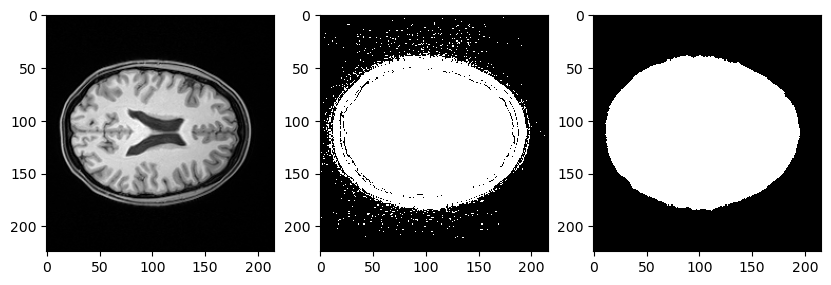

In [23]:
mask_init = ImgT1 > 10
mask = opening(mask_init, disk(2))
mask = closing(mask, disk(3))

fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (10, 10))
axs[0].imshow(ImgT1, cmap = 'gray')
axs[1].imshow(mask_init, cmap = 'gray', interpolation = 'none')
axs[2].imshow(mask, cmap = 'gray', interpolation = 'none')
plt.show()

In [24]:
def my_show_1D_histogram(img, mask, img_name, axs):
    axs[0].imshow(img, cmap = 'gray')
    axs[0].set_title(img_name)
    axs[0].set_axis_off()

    intensities = img[mask]
    axs[1].hist(intensities, bins = 100)
    axs[1].set_title(f'1D Histogram {img_name}')
    axs[1].set_xlabel('Intensities')
    axs[1].set_ylabel('Frequency')

    return intensities

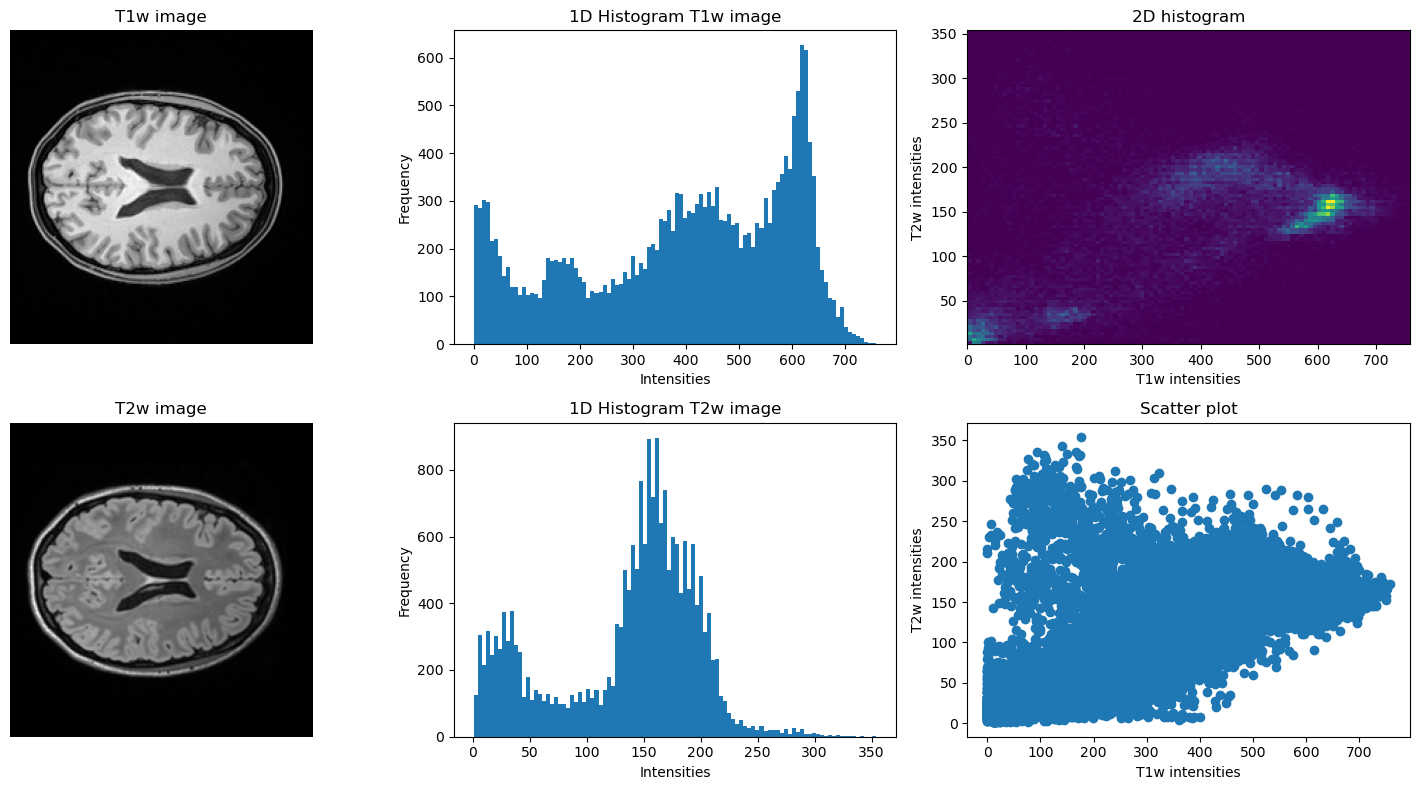

In [25]:
fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize = (15, 8))
T1_intensities = my_show_1D_histogram(ImgT1, mask, 'T1w image', axs[0, 0:2])
T2_intensities = my_show_1D_histogram(ImgT2, mask, 'T2w image', axs[1, 0:2])
axs[0,2].hist2d(T1_intensities, T2_intensities, bins = 100)
axs[0,2].set_xlabel('T1w intensities')
axs[0,2].set_ylabel('T2w intensities')
axs[0,2].set_title('2D histogram')

axs[1,2].scatter(T1_intensities, T2_intensities)
axs[1,2].set_xlabel('T1w intensities')
axs[1,2].set_ylabel('T2w intensities')
axs[1,2].set_title('Scatter plot')
plt.tight_layout()
plt.show()

**Q1**: What is the intensity threshold that can separate the GM and WM classes (roughly) from the 1D histograms?

A1: For T1:about 500 and for T2: about 160

**Q2**: Can the GM and WM intensity classes be observed in the 2D histogram and scatter plot? 

A2: Yes there appear clear two clusters with maxium intensitised in the 2D histogram that represent the two classes distributions 


### Exercise 2

**Q3**: Does the ROI drawings look like what you expect from an expert? 

A3: No, its just some stribes here and there in the outline the intensities of the two classes


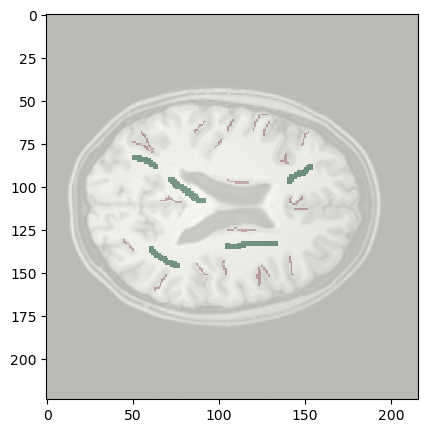

In [26]:
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (5, 5))
axs.imshow(ImgT1, cmap = 'gray')
axs.imshow(ROI_GM, cmap = 'Reds', alpha = 0.5, interpolation = 'none')
axs.imshow(ROI_WM, cmap = 'Greens', alpha = 0.5, interpolation = 'none')
plt.show()

### Exercise 3

**Q4**: What is the difference between the 1D histogram of the training examples and the 1D histogram of the whole image? Is the difference expected?  

A4: It looks very alike the full image histogram except for better class seperation and there is no background


In [27]:
# This is not necessary with the coding style followed in this solution.
qC1 = np.argwhere(ROI_WM) # Shape (399, 2) 
qC2 = np.argwhere(ROI_GM) # (280, 2)

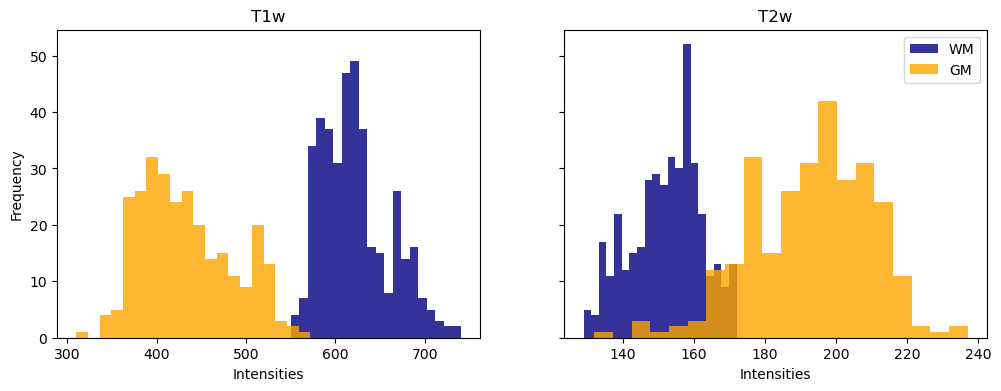

In [28]:
trainWM_T1 = ImgT1[ROI_WM] # trainWM_T1 = ImgT1[qC1[:,0], qC1[:,1]]
trainGM_T1 = ImgT1[ROI_GM] # trainGM_T1 = ImgT1[qC2[:,0], qC2[:,1]]

trainWM_T2 = ImgT2[ROI_WM] # trainWM_T2 = ImgT2[qC1[:,0], qC1[:,1]]
trainGM_T2 = ImgT2[ROI_GM] # trainGM_T2 = ImgT2[qC2[:,0], qC2[:,1]]

fig, axs = plt.subplots(1, 2, figsize = (12, 4), sharex = False, sharey = True)
axs[0].hist(trainWM_T1, bins=20, color = 'navy', label = 'WM', alpha = 0.8)
axs[0].hist(trainGM_T1, bins=20, color = 'orange', label = 'GM', alpha = 0.8)
axs[0].set_ylabel('Frequency')
axs[0].set_xlabel('Intensities')
axs[0].set_title('T1w')

axs[1].hist(trainWM_T2, bins=20, color = 'navy', label = 'WM', alpha = 0.8)
axs[1].hist(trainGM_T2, bins=20, color = 'orange', label = 'GM', alpha = 0.8)
axs[1].set_xlabel('Intensities')
axs[1].set_title('T2w')
plt.legend()
plt.show()


### Exercise 4

In [29]:
# Feature matrix, X -> Shape: (n_samples, n_features)
X1 = np.c_[ImgT1[ROI_WM], ImgT2[ROI_WM]] 
X2 = np.c_[ImgT1[ROI_GM], ImgT2[ROI_GM]]
X = np.r_[X1, X2]

# Label vector, T -> Shape: (n_samples)
n_pixels = X.shape[0]
n_wm_pixels = X1.shape[0]
T = np.zeros((n_pixels, 1))
T[n_wm_pixels:] = 1

In [30]:
X1.shape

(399, 2)

### Exercise 5

**Q5**: How does the class separation appear in the 2D scatter plot compared with 1D histogram. Is it better?

A5: The seperation between the two classes appear to be much better in 2D scatter plot


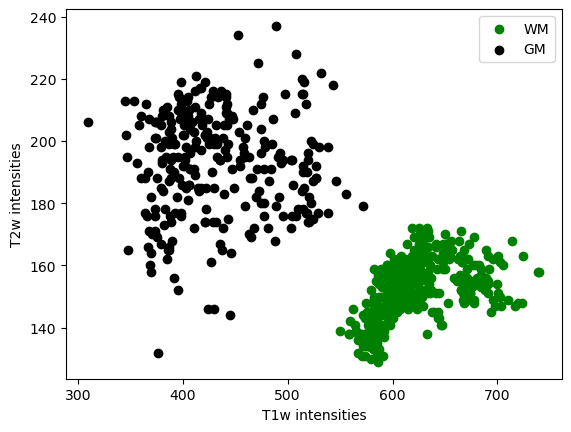

In [31]:
fig, ax = plt.subplots(1,1)
ax.scatter(X1[:,0], X1[:,1], c = 'g', label = 'WM')
ax.scatter(X2[:,0], X2[:,1], c = 'k', label = 'GM')
ax.set_xlabel('T1w intensities')
ax.set_ylabel('T2w intensities')
plt.legend()
plt.show()

### Exercise 6

In [32]:
W = LDA(X, T)

C:\Users\minni\AppData\Local\Temp\ipykernel_24244\289565684.py:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  W[i,0] = -0.5 * temp @ group_mean[i,:].T + np.log(prior_prob[i])


### Exercise 7

In [33]:
Xall= np.c_[ImgT1[mask].flatten(), ImgT2[mask].flatten()]
Y = np.c_[np.ones((len(Xall), 1)), Xall] @ W.T

### Exercise 8

In [34]:
PosteriorProb = np.clip(np.exp(Y) / np.sum(np.exp(Y),1)[:,np.newaxis], 0, 1)

### Exercise 9

In [35]:
posteriorC1 = np.zeros(ImgT1.shape)
posteriorC2 = np.zeros(ImgT1.shape)

posteriorC1[mask] = PosteriorProb[:,0]
posteriorC2[mask] = PosteriorProb[:,1]
mask_WM = posteriorC1 >= 0.5
mask_GM = posteriorC2 > 0.5

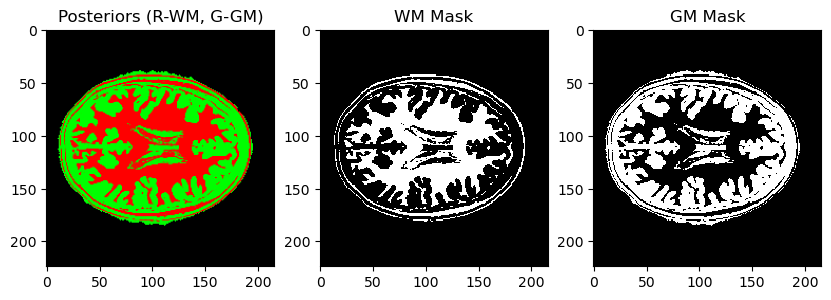

In [36]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (10, 5))
rgb = np.stack((posteriorC1, posteriorC2, np.zeros_like(posteriorC1)), axis = -1).astype(np.double)
axs[0].imshow(rgb)
axs[0].set_title('Posteriors (R-WM, G-GM)')
axs[1].imshow(mask_WM, cmap = 'gray', interpolation = 'none')
axs[1].set_title('WM Mask')
axs[2].imshow(mask_GM, cmap='gray', interpolation = 'none')
axs[2].set_title('GM Mask')
plt.show()

### Exercise 10

**Q6**: Can you identify where the hyper plan is placed i.e. y(x)=0? 

A6: Yes, all the segmented points show a clear line at their
       interface=Hyperplane

**Q7**: Is the linear hyper plane positioned as you expected or would a non-linear hyperplane perform better?

A7: Yes and no - I would expect all black and green training data
       points to be on each side of the hyperplane. Moreover the hyperplane seems
       to be too linear and there seem to be an extras class at the low image
       resolutions. 

**Q8**: Would segmentation be as good as using a single image modality using
    thresholding?

A8: If that should be the case the hyperplane would be orthogonal to one
       of the features. It is not. So no.

**Q9**: From the scatter plot does the segmentation results make sense? Are the two tissue types segmented correctly .

A9: Looks good, but hard to say from a scatter plot


In [37]:
Xall_WM = Xall[PosteriorProb[:,0] > 0.5, :]
Xall_GM = Xall[PosteriorProb[:,1] > 0.5, :]

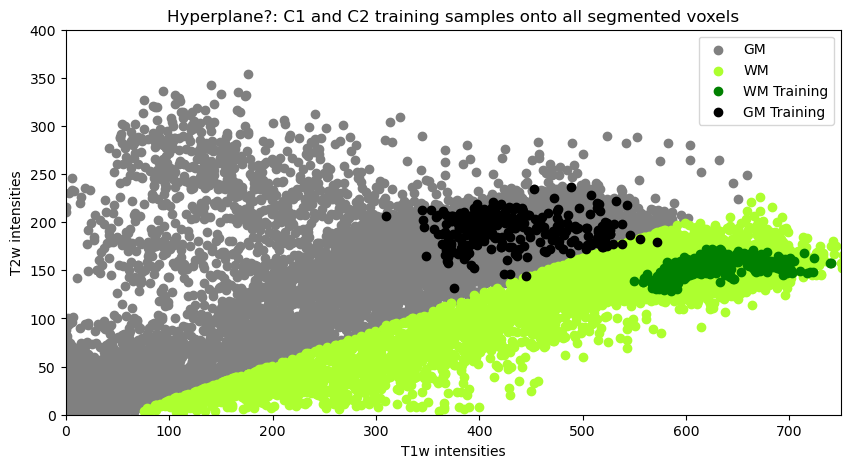

In [38]:
fig, ax = plt.subplots(1,1, figsize = (10,5))
ax.scatter(Xall_GM[:,0], Xall_GM[:,1], c = 'gray', label = 'GM')
ax.scatter(Xall_WM[:,0], Xall_WM[:,1], c = 'greenyellow', label = 'WM')
ax.scatter(X1[:,0], X1[:,1], c = 'g', label = 'WM Training')
ax.scatter(X2[:,0], X2[:,1], c = 'k', label = 'GM Training')
ax.set_xlabel('T1w intensities')
ax.set_ylabel('T2w intensities')
ax.set_title('Hyperplane?: C1 and C2 training samples onto all segmented voxels')

plt.axis([0, 750, 0, 400])
plt.legend()
plt.show()

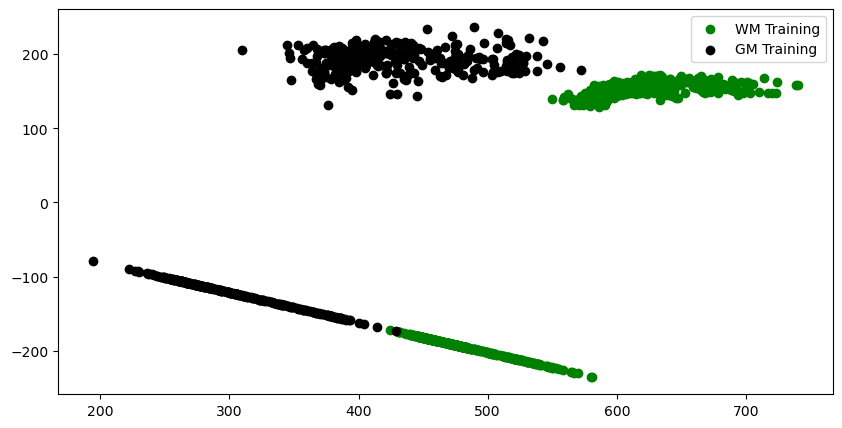

In [39]:
# Projection of the training data onto the hyperplane

fig, ax = plt.subplots(1,1, figsize = (10,5))
ax.scatter(X1[:,0], X1[:,1], c = 'g', label = 'WM Training')
ax.scatter(X2[:,0], X2[:,1], c = 'k', label = 'GM Training')
W_ = W[0,1:] # The weights indicate the normal to the hyperplane, for the projection we need the perpendicular
W_ = (W_/np.linalg.norm(W_))[::-1]
W_[0] = -W_[0]
for point in X1:
  proj = np.dot(point,W_)/np.dot(W_,W_) * W_
  ax.scatter(proj[0],proj[1],color='g')

for point in X2:
  proj = np.dot(point,W_)/np.dot(W_,W_) * W_
  ax.scatter(proj[0],proj[1],color='k')

plt.legend()
plt.show()

# W_ = W[1,1:] # The weights indicate the normal to the hyperplane, for the projection we need the perpendicular
# W_ = (W_/np.linalg.norm(W_))[::-1]
# W_[0] = -W_[0]
# for point in X1:
#   proj = np.dot(point,W_)/np.dot(W_,W_) * W_
#   ax.scatter(proj[0],proj[1],color='r')

# for point in X2:
#   proj = np.dot(point,W_)/np.dot(W_,W_) * W_
#   ax.scatter(proj[0],proj[1],color='b')

### Exercise 11

**Q10**: Are the training examples representative for the segmentation results? Are you surprised that so few training examples perform so well? Do you need to be an anatomical expert to draw these?

A10: Yes they are representative. Yes and no; one do not need to be an anatomical expert, but you need to understand what the method needs as input to perform well.

**Q11**: Compare the segmentation results with the original image. Is the segmentation results satisfactory? Why not?

A11: Yes, the WM and GM classes looks correct segmented when comparing to the anatomical structures in ImgT1 and ImgT2.

**Q12**: Is one class completely wrong segmented? What is the problem?

A12: Yes - If you have not masked out the backgroud voxels, all background and skull voxels also are classified as GM. Solution is to identify the background voxels and exclude these from the segmentation or to add an extra class for background/skull voxels. Also the CSF class is segmented as both GM and WM. The segmentation problem is that there are more classes in the image than the classifier has been trained to segment.


In [40]:
tmp = np.zeros(mask_WM.shape)
red_WM = np.stack((mask_WM, tmp, tmp), axis = -1)
green_GM = np.stack((tmp, mask_GM, tmp), axis = -1)

In [41]:
def overlay_segmentation(I, M):
    I = I/I.max()
    I_aux, I_red = I.copy(), I.copy()
    I_aux[M] = 0
    I_red[M] = 1
    tmp = np.stack((I_red, I_aux, I_aux), axis = -1)
    return tmp

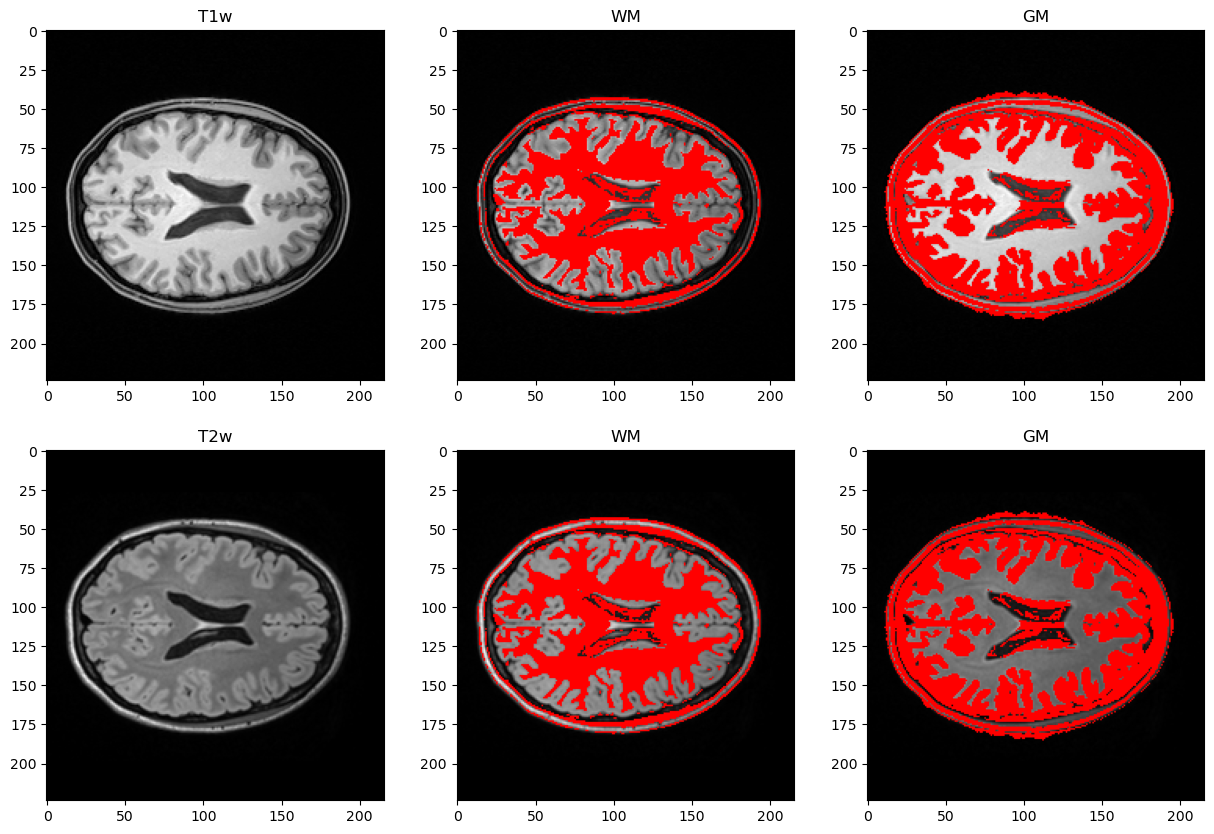

In [42]:
fig, axs = plt.subplots(2, 3, figsize = (15, 10))
axs[0,0].imshow(ImgT1, cmap = 'gray')
axs[0,0].set_title('T1w')
axs[0,1].imshow(overlay_segmentation(ImgT1, mask_WM))
axs[0,1].set_title('WM')
axs[0,2].imshow(overlay_segmentation(ImgT1, mask_GM))
axs[0,2].set_title('GM')

axs[1,0].imshow(ImgT2, cmap = 'gray')
axs[1,0].set_title('T2w')
axs[1,1].imshow(overlay_segmentation(ImgT2, mask_WM))
axs[1,1].set_title('WM')
axs[1,2].imshow(overlay_segmentation(ImgT2, mask_GM))
axs[1,2].set_title('GM')

plt.show()